# High-level Keras (TF) Example

In this example, we show how to deploy the trained Keras (tensorflow) model as a web service through [Azure CLI](https://azure.microsoft.com/en-us/blog/announcing-general-availability-of-vm-storage-and-network-azure-cli-2-0/). The target machine learning problem is [CIFAR-10 - Object Recognition in Images](https://www.kaggle.com/c/cifar-10). Section [Model Training](#training) shows the same steps as the steps shown in this [High-level Keras (TF) Example](https://github.com/ilkarman/DeepLearningFrameworks/blob/master/notebooks/Keras_TF_CNN.ipynb). By executing the scripts in this section, we train the Keras network and evaluate the trained model on testing data. In Section [Model Deployment](#deploy), we show the steps to save a Keras model, deploy the model through Azure CLI, and test the deployed web service. 


## Outline<a id="BackToTop"></a>
- [Prerequisite](#prerequisite)
- [Model Training](#training)
- [Model Deployment](#deploy)
  - [Save the model](#save_model)
  - [Write a scoring script](#score_script)
  - [Test the trained model at local envionment](#test_local)
  - [Deploy model as a Web Service](#deploy_model)
  - [Test Web Service](#test_ws)
  - [Debug Web Service](#debug_ws)
  - [Clean up resources](#cleanup)

## Prerequisite <a id="Prerequisite"></a>

- Azure subscription
- Data Science Virtual Machine (DSVM) on Azure
    
    In this example, we use Deep Learning Virtual Machine - Linux OS, Standard [NC6 (6 vcpus, 56 GB memory) machine](https://azure.microsoft.com/en-us/blog/azure-n-series-preview-availability/) as the compute resource, where we train and deploy the model.  

    The Deep Learning Virtual Machine (DLVM) is a specially configured variant of the Data Science Virtual Machine (DSVM) to make it easier to use GPU-based VM instances for training deep learning models. It is supported on Windows 2016, or the Ubuntu Data Science Virtual Machine and shares the same core VM images (and hence all the rich toolset) as the DSVM. We also provide end-to-end AI samples for image and text understanding. The deep learning virtual machine also makes the rich set of tools and samples on the DSVM more easily discoverable. In terms of the tooling, the Deep Learning Virtual Machine provides several popular deep learning frameworks, tools to acquire and pre-process image, textual data.
    
    We use following tools on this DSVM.
    - Python 3
    - Jupyter Notebook 
    - Azure CLI 

### Compute Environment Configuration

1. Jupyter Server. It matters where and how the Jupyter server is launched. In order to make the remaining tutorial smooth, please follow below two steps to launch Jupyter server. In VM's bash console, (1) switch to use py35 conda env by exectuting `source activate py35`, and (2) launch Jupyter server from `py35` conda environment manually.

2. As a prerequisite, Azure CLI must be configured to make a set of "az ml" commands work for [model management](https://docs.microsoft.com/en-us/azure/machine-learning/preview/model-management-cli-reference). In a notebook cell, type `az -h` and `az ml -h`. The output should look similar as below screenshots. This check ensure relevant commands works in the [Deploy model as a Web Service](#deploy_model) section. 

![azcheck](./imgs/azcheck.PNG)

![azmlcheck](./imgs/azmlcheck.PNG)

## Model Training <a id="training"></a>

In [4]:
import os
import sys
import numpy as np
os.environ['KERAS_BACKEND'] = "tensorflow"
import keras as K
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from common.params import *
from common.utils import *

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Force one-gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
# Performance Improvement
# 1. Make sure channels-first (not last)
K.backend.set_image_data_format('channels_first')

In [7]:
print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", K.__version__)
print("Numpy: ", np.__version__)
print("Tensorflow: ", tensorflow.__version__)
print(K.backend.backend())
print(K.backend.image_data_format())
print("GPU: ", get_gpu_name())
print(get_cuda_version())
print("CuDNN Version ", get_cudnn_version())

OS:  linux
Python:  3.5.4 |Anaconda custom (64-bit)| (default, Nov 20 2017, 18:44:38) 
[GCC 7.2.0]
Keras:  2.1.4
Numpy:  1.14.1
Tensorflow:  1.6.0
tensorflow
channels_first
GPU:  ['Tesla K80']
CUDA Version 9.0.176
CuDNN Version  7.0.5


In [8]:
def create_symbol(n_classes=N_CLASSES):
    model = Sequential()
    
    model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation='relu',
                     input_shape=(3, 32, 32)))
    model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(100, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(100, kernel_size=(3, 3), padding='same', activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [9]:
def init_model(m, lr=LR, momentum=MOMENTUM):
    m.compile(
        loss = "categorical_crossentropy",
        optimizer = K.optimizers.SGD(lr, momentum),
        metrics = ['accuracy'])
    return m

In [10]:
%%time
# Data into format for library
x_train, x_test, y_train, y_test = cifar_for_library(channel_first=True, one_hot=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

Preparing train set...
Data does not exist. Downloading https://ikpublictutorial.blob.core.windows.net/deeplearningframeworks/cifar-10-python.tar.gz
Extracting files...
Preparing train set...
Preparing test set...
(50000, 3, 32, 32) (10000, 3, 32, 32) (50000, 10) (10000, 10)
float32 float32 int32 int32
CPU times: user 2.77 s, sys: 971 ms, total: 3.74 s
Wall time: 8.96 s


In [11]:
%%time
# Load symbol
sym = create_symbol()

CPU times: user 431 ms, sys: 2.67 s, total: 3.1 s
Wall time: 26.7 s


In [12]:
%%time
# Initialise model
model = init_model(sym)

CPU times: user 28.2 ms, sys: 36 µs, total: 28.2 ms
Wall time: 27.5 ms


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 32, 32)        1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 32, 32)        22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 16, 16)       45100     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 16, 16)       90100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 8, 8)         0         
__________

In [14]:
%%time
# Main training loop: 1m16s
model.fit(x_train,
          y_train,
          batch_size=BATCHSIZE,
          epochs=EPOCHS,
          verbose=1)

Epoch 1/10
50000/50000 [==============================] - 36s 725us/step - loss: 1.8333 - acc: 0.3284
Epoch 2/10
50000/50000 [==============================] - 19s 381us/step - loss: 1.3486 - acc: 0.5118
Epoch 3/10
50000/50000 [==============================] - 19s 382us/step - loss: 1.1134 - acc: 0.6009
Epoch 4/10
50000/50000 [==============================] - 19s 382us/step - loss: 0.9449 - acc: 0.6667
Epoch 5/10
50000/50000 [==============================] - 19s 384us/step - loss: 0.8390 - acc: 0.7046
Epoch 6/10
50000/50000 [==============================] - 19s 384us/step - loss: 0.7546 - acc: 0.7338
Epoch 7/10
50000/50000 [==============================] - 20s 391us/step - loss: 0.6857 - acc: 0.7576
Epoch 8/10
50000/50000 [==============================] - 19s 384us/step - loss: 0.6282 - acc: 0.7786
Epoch 9/10
50000/50000 [==============================] - 20s 391us/step - loss: 0.5790 - acc: 0.7972
Epoch 10/10
50000/50000 [==============================] - 19s 387us/step - loss: 

In [15]:
%%time
# Main evaluation loop
y_guess = model.predict(x_test, batch_size=BATCHSIZE)
y_guess = np.argmax(y_guess, axis=-1)
y_truth = np.argmax(y_test, axis=-1)

CPU times: user 557 ms, sys: 69.3 ms, total: 626 ms
Wall time: 1.33 s


In [16]:
print("Accuracy: ", 1.*sum(y_guess == y_truth)/len(y_guess))

Accuracy:  0.7799


## Model Deployment <a id="deploy"></a>

- [Save the model](#save_model)
- [Write a scoring script](#score_script)
- [Test the trained model at local envionment](#test_local)
- [Deploy model as a Web Service](#deploy_model)
- [Test Web Service](#test_ws)
- [Debug Web Service](#debug_ws)
- [Clean up resources](#cleanup)

### Save the model <a id="save_model"></a>

In [17]:
#get the current working directory
print(os.getcwd()) 

#list files in current working directory
# os.listdir(os.curdir)

/dsvm/Notebooks/DeepLearningModelDeployment


In [18]:
local_path = os.getcwd()
o16n_path = os.path.join(local_path,'o16n')  
model_path = os.path.join(o16n_path,'kerastfmodel')
model_file_name = os.path.join(model_path,'kerastfmodel.h5')
score_file_name = os.path.join(model_path, 'score.py')


if not os.path.exists(local_path):
    os.makedirs(local_path)
if not os.path.exists(o16n_path):
    os.makedirs(o16n_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [19]:
print(model_path)
print(score_file_name)

/dsvm/Notebooks/DeepLearningModelDeployment/o16n/kerastfmodel
/dsvm/Notebooks/DeepLearningModelDeployment/o16n/kerastfmodel/score.py


In [20]:
# Save the Model
model.save(model_file_name)

### Write a scoring script¶<a id="score_script"></a>
In order to create a web service, you will create a scoring script that will load the models, perform the prediction, and return the result. Azure ML uses init() and run() functions inside this scoring script for that purpose. The init() function initializes the web service and loads the saved model. The run() function uses the model and the input data to return a prediction which is executed on a scoring call.

In [21]:
%%writefile $score_file_name

import numpy as np
import os
import sys
import keras as K
from io import BytesIO
from PIL import Image, ImageOps
import base64
import json

def init():
    
    global model  

    print("Executing init() method...")
    print("Python version: " + str(sys.version) + ", keras version: " + K.__version__)
    # Load the model 
    model = K.models.load_model('kerastfmodel.h5')
    return


def run(inputString):
    
    responses = []
    base64Dict = json.loads(inputString)

    for k, v in base64Dict.items():
        img_file_name, base64Img = k, v
    decoded_img = base64.b64decode(base64Img)
    img_buffer = BytesIO(decoded_img)
    imageData = Image.open(img_buffer).convert("RGB")

    # Evaluate the model using the input data
    img = ImageOps.fit(imageData, (32, 32), Image.ANTIALIAS)
    img_conv = np.array(img) # shape: (32, 32, 3)
    # Scale pixel intensity
    x_test = img_conv / 255.0
    # Reshape
    x_test = np.moveaxis(x_test, -1, 0)
    x_test = np.expand_dims(x_test, 0)  # shape (1, 3, 32, 32)

    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=-1)
    # print(y_pred)
    LABELS = ["airplane", "automobile", "bird", "cat", "deer", "fog", "frog", "horse", "ship", "truck"]
    resp = {img_file_name: str(LABELS[y_pred[0]])}

    responses.append(resp)
    return json.dumps(responses)
    
  
if __name__ == "__main__":
    init()
    # input data
    img_path = 'automobile8.png'
    encoded = None
    with open(img_path, 'rb') as file:
      encoded = base64.b64encode(file.read())
    img_dict = {img_path: encoded.decode('utf-8')}
    body = json.dumps(img_dict)
    resp = run(body)
    print(resp)

Writing /dsvm/Notebooks/DeepLearningModelDeployment/o16n/kerastfmodel/score.py


### Test the trained model at local envionment <a id="test_local"></a>

We test the trained model by supplying a test image to the model and checking the prediction.

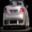

In [22]:
from PIL import Image
test_img_name = os.path.join(local_path,'common/automobile8.png')
Image.open(test_img_name)

In [23]:
# In order to test the score.py, copy the test image to the same directory where score.py is
import shutil
shutil.copyfile(test_img_name, os.path.join(model_path, os.path.split(test_img_name)[1]))

'/dsvm/Notebooks/DeepLearningModelDeployment/o16n/kerastfmodel/automobile8.png'

In [24]:
# Check if the image, scoring script and model are in the same folder.
os.listdir(model_path)

['automobile8.png', 'kerastfmodel.h5', 'score.py']

In [29]:
# Change the current working directory to model_path
os.chdir(model_path)
#list files in current working directory
os.listdir(os.curdir)

['automobile8.png', 'kerastfmodel.h5', 'score.py']

In [30]:
!python score.py

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Executing init() method...
Python version: 3.5.4 |Anaconda custom (64-bit)| (default, Nov 20 2017, 18:44:38) 
[GCC 7.2.0], keras version: 2.1.4
2018-05-04 15:06:21.696517: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-05-04 15:06:21.790625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: f7e4:00:00.0
totalMemory: 11.17GiB freeMemory: 418.31MiB
2018-05-04 15:06:21.790690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1312] Adding vis

### Deploy model as a Web Service <a id="deploy_model"></a>

In this section, we show the steps to deploy the previously trained model on [Azure Container Service (ACS)](https://azuremarketplace.microsoft.com/en-us/marketplace/apps/microsoft.acs) via [Azure CLI](https://azure.microsoft.com/en-us/blog/announcing-general-availability-of-vm-storage-and-network-azure-cli-2-0/). 

During this section, following Azure resources will be created:
    
    - Resource group defined in variable YOUR_RESOURCE_GROUP
        * Machine Learning Model Management
        * cluster environment (Microsoft.MachineLearningCompute/operationalizationClusters)
    - Resource group created during the cluster environment provision (YOUR_RESOURCE_GROUP plus"-azureml-xxxxx") 
        * Container registry
        * Container service
        * .... a bunch of other automatically provisoned resources

In [31]:
# Copy conda_dependencies.yml file into the directory model_path. 
import shutil
yml_file_name = os.path.join(local_path,'common/conda_dependencies.yml')
shutil.copyfile(yml_file_name, os.path.join(model_path, os.path.split(yml_file_name)[1]))

'/dsvm/Notebooks/DeepLearningModelDeployment/o16n/kerastfmodel/conda_dependencies.yml'

In [48]:
#list files in current working directory
os.listdir(os.curdir)

['automobile8.png', 'kerastfmodel.h5', 'conda_dependencies.yml', 'score.py']

In [ ]:
# login your Azure account and set Azure subscription
!az login

When executing `!az login`, you will see following output message: To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code xxxxxxx to authenticate. Finish this login task in a browser and close the browser page.

In [36]:
# Create Variable Names for Deployment
SUB_Name = 'Your Azure Subscription name'  # Azure Subscription name
LOCATION = 'Pick an Azure Region Here!! e.g. eastus2' # resource location
DEPLOY_NAME = 'Pick a Deployment Name Here!!' 
YOUR_RESOURCE_GROUP = DEPLOY_NAME + 'rg' 
MM_ACCOUNT = DEPLOY_NAME + 'mmacc'     
CLUSTER_SERVICE_NAME = DEPLOY_NAME + 'clus' + 'srvc'
CLUSTER_ENV_NAME = DEPLOY_NAME + 'clus' + 'env'

In [37]:
!az account set -s $SUB_Name

In [4]:
# Create a resource group
!az group create --l $LOCATION --name $YOUR_RESOURCE_GROUP

{
  "id": "/subscriptions/edf507a2-6235-46c5-b560-fd463ba2e771/resourceGroups/yanzimgrg",
  "location": "eastus2",
  "managedBy": null,
  "name": "yanzimgrg",
  "properties": {
    "provisioningState": "Succeeded"
  },
  "tags": null
}


In [ ]:
# execute following command to create a Machine Learning Model Management resource in the resource group
!az ml account modelmanagement create -l $LOCATION -n $MM_ACCOUNT -g $YOUR_RESOURCE_GROUP

In [2]:
# Execute fllowing command to create the cluster environment (Microsoft.MachineLearningCompute/operationalizationClusters)
# Execute fllowing command in CLI, at the prompt type 'Y' (Q: Continue with this subscription (Y/n)?)
# !az ml env setup --cluster -l $LOCATION -n $CLUSTER_ENV_NAME -g $YOUR_RESOURCE_GROUP
print('az ml env setup --cluster -l ', LOCATION, '-n ', CLUSTER_ENV_NAME,'-g ', YOUR_RESOURCE_GROUP)

az ml env setup --cluster -l  eastus2 -n  yanzimgclusenv -g  yanzimgrg


In [ ]:
# You can check the information on the environment with the following command. 
!az ml env show -g $YOUR_RESOURCE_GROUP -n $CLUSTER_ENV_NAME

> [NOTE] You will need to wait until "Provisioning State" is set to "Succeeded" to continue with the next steps. Check the state by running the cell again until you see Succeeded. The estimated waiting time is 15-20 minutes. When successfully provisioned, you will see a new resource group created in your Azure subscription with a bunch of resources in it. The name of this new resource group is YOUR_RESOURCE_GROUP plus"-azureml-xxxxx". For example, my resource group name is "yanzimgrg" and the newly created resource group name is "yanzimgrg-azureml-a0c61".

In [39]:
!az ml account modelmanagement set -n $MM_ACCOUNT -g $YOUR_RESOURCE_GROUP

{
  "created_on": "2018-04-04T13:18:49.76867Z",
  "description": "",
  "id": "/subscriptions/edf507a2-6235-46c5-b560-fd463ba2e771/resourceGroups/yanzimgrg/providers/Microsoft.MachineLearningModelManagement/accounts/yanzimgmmacc",
  "location": "eastus2",
  "model_management_swagger_location": "https://eastus2.modelmanagement.azureml.net/api/subscriptions/edf507a2-6235-46c5-b560-fd463ba2e771/resourceGroups/yanzimgrg/accounts/yanzimgmmacc/swagger.json?api-version=2017-09-01-preview",
  "modified_on": "2018-04-04T13:18:49.76867Z",
  "name": "yanzimgmmacc",
  "resource_group": "yanzimgrg",
  "sku": {
    "capacity": 1,
    "name": "S1"
  },
  "subscription": "edf507a2-6235-46c5-b560-fd463ba2e771",
  "tags": {},
  "type": "Microsoft.MachineLearningModelManagement/accounts"
}


In [40]:
!az ml env set -g $YOUR_RESOURCE_GROUP -n $CLUSTER_ENV_NAME

Ensure /home/mylogin/bin/kubectl is on the path to avoid seeing this message in the future.
Kubectl dashboard started for cluster at this endpoint: 127.0.0.1:37785/ui
Compute set to yanzimgclusenv.


In [41]:
# Change the current working directory to model_path
# os.chdir(model_path)
# list files in current working directory
# Make sure current directory contains 'score.py', 'kerastfmodel.h5', and 'conda_dependencies.yml'
os.listdir(os.curdir)

['automobile8.png', 'kerastfmodel.h5', 'conda_dependencies.yml', 'score.py']

In [ ]:
# create web service - this step can take several minutes
!az ml service create realtime --model-file kerastfmodel.h5 -f score.py -n $CLUSTER_SERVICE_NAME -r python -c conda_dependencies.yml

In [15]:
CLUSTER_SERVICE_ID = 'Your cluster service Id here!!'

### Test Web Service <a id="test_ws"></a>

In [33]:
import os
import base64
import requests
import json
import zipfile
from azure.storage.blob import BlockBlobService
from PIL import Image

In [43]:
# Use following command to get the service URL and other details for calling the service endpoint. 
!az ml service usage realtime -i $CLUSTER_SERVICE_ID

Scoring URL:
    http://40.84.41.97/api/v1/service/yanzimgclussrvc/score

Headers:
    Content-Type: application/json
    Authorization: Bearer <key>
        (<key> can be found by running 'az ml service keys realtime -i yanzimgclussrvc.yanzimgclusenv-08525303.eastus2')

Swagger URL:
    http://40.84.41.97/api/v1/service/yanzimgclussrvc/swagger.json

Sample CLI command:
    az ml service run realtime -i yanzimgclussrvc.yanzimgclusenv-08525303.eastus2 -d !! YOUR DATA HERE !!

Sample CURL call:
    curl -X POST -H "Content-Type:application/json" -H "Authorization:Bearer <key>" --data !! YOUR DATA HERE !! http://40.84.41.97/api/v1/service/yanzimgclussrvc/score

Get debug logs by calling:
    az ml service logs realtime -i yanzimgclussrvc.yanzimgclusenv-08525303.eastus2

Get STDOUT/STDERR or Request/Response logs in App Insights:
    https://analytics.applicationinsights.io/subscriptions/edf507a2-6235-46c5-b560-fd463ba2e771/resourcegroups/yanzimgrg-azureml-56b1e/components/mlcrpai311162063

In [36]:
url = 'Your Scoring URL Here!!'
# e.g. url = 'http://40.84.41.97/api/v1/service/yanzimgclussrvc/score'

In [29]:
!az ml service keys realtime -i $CLUSTER_SERVICE_ID

PrimaryKey: 1efdf6b213ed4fd69f5bf47ae1a7fc60
SecondaryKey: 39780a70114a4acfb5f85894b1f02660


In [30]:
api_key = 'Your Api Key Here!!'
# e.g. api_key = '1efdf6b213ed4fd69f5bf47ae1a7fc60'

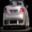

In [23]:
# the test image to predict on
test_img_name = 'automobile8.png'
Image.open(test_img_name)

In [34]:
img_file_name = os.path.split(test_img_name)[1]
print(img_file_name)
# prepare a test image
with open(test_img_name, 'rb') as file:
  encoded = base64.b64encode(file.read())
img_dict = {img_file_name: encoded.decode('utf-8')}
body = json.dumps(img_dict)

automobile8.png


In [37]:
# call the web service end point
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
response = requests.post(url, headers=headers, data=body)
response

<Response [200]>

In [38]:
prediction = json.loads(response.content.decode('ascii'))
prediction # The firt part is the test image's name, and the second part is the predicted category. 

'[{"automobile8.png": "automobile"}]'

### Debug Web Service <a id="debug_ws"></a>

When the deployed web service does not behave as what you expected, you may want to debug it. You can add a couple "print" statement in score.py, deploy the web service, and get the log file by executing following command.  

In [ ]:
# the log file wslog.txt will be generated in the current working directory
!az ml service logs realtime -i $CLUSTER_SERVICE_ID > wslog.txt

> [NOTE]: You need to delete the deployed web service before creating a new web service with the same name. Even if it shows that the web service deployment fails, you still need to delete it first. 

> In Azure portal, you can find the information about the deployed web service in the "Machine Learning Model Management" in YOUR_RESOURCE_GROUP.

In [19]:
# You can delete a web service by executing following command. 
!az ml service delete realtime -i $CLUSTER_SERVICE_ID

Service to delete yanzimgclussrvc.yanzimgclusenv-08525303.eastus2 not found.


In [43]:
!az ml service delete realtime -i amlcvtkobjws.yanzimgclusenv-08525303.eastus2

Successfully deleted service: amlcvtkobjws.yanzimgclusenv-08525303.eastus2


### Clean up resources <a id="cleanup"></a>

When you finish this example, you may want to avoid unnecessary cost by cleaning up the Azure resources you have provisioned. You need to delete two resource groups: YOUR_RESOURCE_GROUP and YOUR_RESOURCE_GROUP plus"-azureml-xxxxx". The exact name for the second resource group can be found in your Azure portal. For example, my resource group name is YOUR_RESOURCE_GROUP = "yanzimgrg" and the other system created resource group name is "yanzimgrg-azureml-a0c61". I then need to execute following commands to delete these two resource groups.

    az group delete -n yanzimgrg
    az group delete -n yanzimgrg-azureml-a0c61

In [44]:
# Delete resource group. Execute this command in cmd console. 
# Execute below command in CLI console, at the prompt type "y" (Q: Are you sure you want to perform this operation? (y/n):) 
# az group delete -n $YOUR_RESOURCE_GROUP
print("az group delete -n ", YOUR_RESOURCE_GROUP)

az group delete -n  yanzimgrg
